In [ ]:
# Install dependencies
%pip install ultralytics
%pip install torch
%pip install torchvision
%pip install torchaudio
%pip install opencv-python
%pip install timm
%pip install easydict

'c:\\Users\\esabh\\OneDrive\\Documents\\GitHub\\Follow-me-bot'

In [ ]:
# Import necessary libraries
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import time
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort
from deep_sort.sort.tracker import Tracker

### Human detection using YOLOv8
To keep the computation real-time friendly, the lighter *YOLOv8s* variant is used but other variants can also be used.


0: 640x384 4 persons, 370.2ms
Speed: 2.4ms preprocess, 370.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)


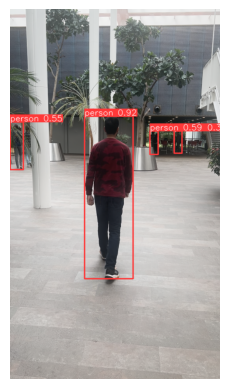

In [2]:
# Load a YOLOv8 model
# YOLOv8 variants:
# Top to Down: Small size, low accuracy -> Large size, high accuracy
#     yolov8n.pt
#     yolov8s.pt
#     yolov8m.pt
#     yolov8l.pt
#     yolov8x.pt

model = YOLO("yolov8s.pt") # yolov8s.pt

# Load a test image
path = 'data/test_img.png'
img = cv2.imread(path)

# Detect human using YOLO
classes = [0]   # Human class
results = model(img, classes=classes)

# Display the results
detect_img = results[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

plt.imshow(detect_img)
plt.axis('off')
plt.show()

### Computing depth using MiDAS
The smallest variant i.e., *MiDaS_small* is used here but other variants can also be used. The computed depth values are inversely proportional to the actual depth and have no units. During the first run, this will download the model weights and store it in cache, hence an internet connection is required to run it.

In [3]:
# Load MiDAS model
# Different MiDAS models:
# Top to Down: Large, more accuracy -> Small, less accurate
#     "DPT_Large"
#     "DPT_Hybrid"
#     "MiDaS_small"

model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# If GPU available, map MiDAS execution to GPU else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

# Image transformation depending on MiDAS model type
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\esabh/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master


In [ ]:
# Function to get depth map using MiDAS
def get_depth_map(img):
    input_batch = transform(img).to(device)
    # Perform depth prediction using MiDAS
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert the depth map tensor to a NumPy array for plotting
    depth_map = prediction.cpu().numpy()
    return depth_map

# Function to scale MiDAS depth map to real world distance in mm
def distance_to_object(real_object_height_mm, image_height_px, object_height_px):
    focal_length_sensor_height_ratio = 0.827433 # IPhone 14 Pro Max camera parameter
    return focal_length_sensor_height_ratio * real_object_height_mm * image_height_px/ (object_height_px)

Text(0.5, 1.0, 'Depth Map')

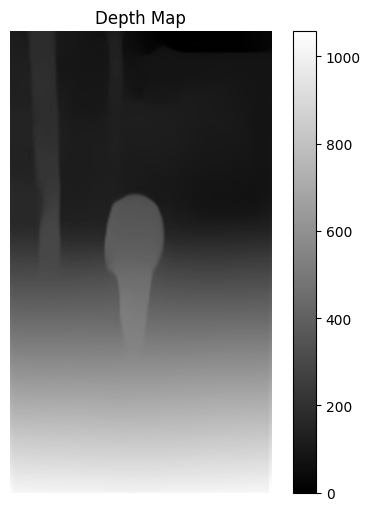

In [6]:
# Run and view results from depth map function
depth_map = get_depth_map(img)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(depth_map, cmap='gray')
plt.colorbar()
plt.title('Depth Map')

### Tracking using DeepSORT
YOLO will detect all humans visible in the frame but only the first human detected (our person of interest) will be tracked using DeepSORT. Average metric depth value of all the pixels inside the tracked human's bounding box is displayed. Tracking is applied for a video and the output will be stored as `data/output.mp4`.

In [7]:
# Function to process a single frame
def process_frame(frame):
    og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = og_frame.copy()
    classes = [0]   # Human class
    result = model(frame, device=device, classes=classes)

    boxes = result[0].boxes  # Boxes object for bbox outputs
    probs = result[0].probs  # Class probabilities for classification outputs
    cls = boxes.cls.tolist()  # Convert tensor to list
    conf = boxes.conf
    xywh = boxes.xywh  # box with xywh format

    conf = conf.detach().cpu().numpy()
    bboxes_xywh = xywh
    bboxes_xywh = xywh.cpu().numpy()
    bboxes_xywh = np.array(bboxes_xywh, dtype=float)

    tracks = tracker.update(bboxes_xywh, conf, og_frame) # setting up the tracker

    for track in tracker.tracker.tracks:
        # Track only the first human detected (Track ID 1)
        if(track.track_id == 1):
            hits = track.hits
            # Get bounding box coordinates in (x1, y1, x2, y2) format
            x1, y1, x2, y2 = track.to_tlbr()  
            depth_in_mm = distance_to_object(person_height, frame.shape[0], y2-y1)
            # Draw a rectangle and print depth value under the bounding box
            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            depth_text = f"{depth_in_mm/1000:.2f} m"
            cv2.putText(og_frame, depth_text, (int(x1), int(y2+25)), font, 1, (0,0,0), 2, cv2.LINE_AA)

    return og_frame

In [8]:
# Set input and output video path
video_path = "data/test_vid.mp4"
output_path = "data/output.mp4"

# Load DeepSORT model
deep_sort_weights = 'deep_sort/deep/checkpoint/ckpt.t7' #load the pretrained model
tracker = DeepSort(model_path=deep_sort_weights, max_age=2000)
classes = [0]  # Person
class_name = 'person'

# Get the video properties
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
# Define the output format and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
# Initialise variables
counter, fps, elapsed = 0, 0, 0
start_time = time.perf_counter()
# Scale for depth inversion
scale = 0.01 
alpha = 0.2
previous_depth = 0.0
while True:
    ret, frame = cap.read()
    if ret:
        # Get and display depth from frame
        og_frame = process_frame(frame)

        # Update FPS and place on frame
        current_time = time.perf_counter()
        elapsed = (current_time - start_time)
        counter += 1
        if elapsed > 1:
            fps = counter / elapsed
            counter = 0
            start_time = current_time

        # Write the frame to the output video file
        out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 1 person, 344.6ms
Speed: 2.5ms preprocess, 344.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 339.8ms
Speed: 1.2ms preprocess, 339.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 337.4ms
Speed: 2.2ms preprocess, 337.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 346.7ms
Speed: 1.2ms preprocess, 346.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 342.7ms
Speed: 1.0ms preprocess, 342.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 331.0ms
Speed: 1.0ms preprocess, 331.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 348.9ms
Speed: 1.1ms preprocess, 348.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 336.0ms
Speed: 7.1ms preprocess, 336.0ms inference, 1.0ms postprocess per image at